In [8]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import utils
import numpy as np

In [9]:
# Размер изображения (28*28 пикселей)
# 60000 обучающих изображений
# 10000 для тетирования
(x_train,y_train),(x_test,y_test)  = fashion_mnist.load_data() 

x_train = x_train.reshape((60000, 28, 28, 1))
x_train = x_train.astype('float32') / 255

x_test = x_test.reshape((10000, 28, 28, 1))
x_test = x_test.astype('float32') / 255

y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)

In [79]:
model = Sequential()

#Свёрточная часть
model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

#Классификатор
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))


# Компиляция
# оптимизатор RMSProp, реализующий градиентный спуск с импульсом
#Импульс вводится для решения двух проблем SGD: невысокой скорости сходимости и попадания в локальный минимум
# Веса изменяются в зависимости от текущего значения градиента, и от градиента на предыдущем шаге
model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=["accuracy"])

history = model.fit(x_train, y_train, epochs=5, batch_size=64)
test_loss, test_acc = model.evaluate(x_test, y_test)
print(test_acc)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 73s 1ms/sample - loss: 0.4542 - accuracy: 0.8337
Epoch 2/5
60000/60000 [==============================] - 66s 1ms/sample - loss: 0.3055 - accuracy: 0.8888
Epoch 3/5
60000/60000 [==============================] - 66s 1ms/sample - loss: 0.2640 - accuracy: 0.9042
Epoch 4/5
60000/60000 [==============================] - 66s 1ms/sample - loss: 0.2418 - accuracy: 0.9115
Epoch 5/5
60000/60000 [==============================] - 66s 1ms/sample - loss: 0.2258 - accuracy: 0.9174
10000/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.9154


In [80]:
model.save("fashion_mnist_cnn.h5")

In [81]:
from tensorflow.keras.models import load_model
loaded_model = load_model("fashion_mnist_cnn.h5")
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_4 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
activation_5 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7744)             

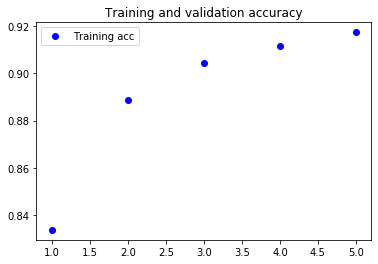

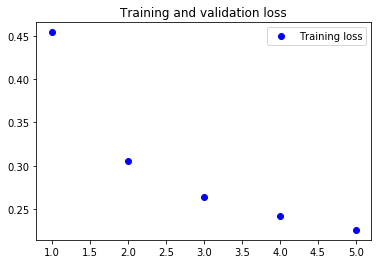

In [82]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Визуализация сверточных слоев

In [126]:
img_array = x_test[2]
print(img_array.shape)
img_array = np.expand_dims(img_array, axis=0)
print(img_array.shape)
print(img_array[0,:,:,0].shape)#x[:, :, 0]

(28, 28, 1)
(1, 28, 28, 1)
(28, 28)


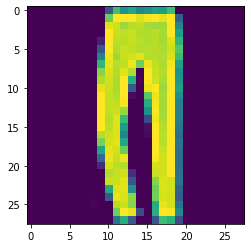

In [127]:
import matplotlib.pyplot as plt
plt.imshow(img_array[0,:,:,0]) # img (28*28)
plt.show()

In [172]:
from tensorflow.python.keras.models import Model
#0 3
activation_model = Model(inputs=loaded_model.input, outputs=loaded_model.layers[3].output)

In [173]:
activation_model.summary()

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_4 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 64)        18496     
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


In [174]:
activation = activation_model.predict(img_array)
print(activation.shape)

(1, 11, 11, 64)


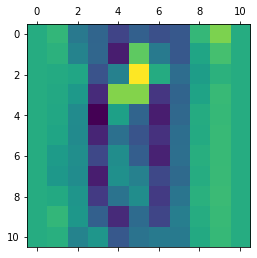

In [175]:
plt.matshow(activation[0, :, :, 31], cmap='viridis')

In [176]:
images_per_row = 16
n_filters = activation.shape[-1] #Количество признаков в карте признаков
print(n_filters)
size = activation.shape[1] #Размер изображения в канале. Карта признаков имеет форму (1, size, size, n_features)
print(size)
n_cols = n_filters // images_per_row #Количество колонок в матрице отображения каналов
print(n_cols)

display_grid = np.zeros((n_cols * size, images_per_row * size))

64
11
4


In [177]:
for col in range(n_cols):
    for row in range(images_per_row):
        channel_image = activation[0, :, :, col * images_per_row + row]
        #Заключительная обработка признака, чтобы получить приемлемую визуализацию
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image #Вывод сетки

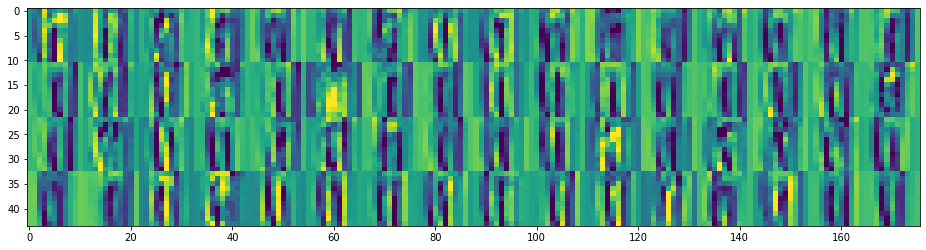

In [182]:
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [26]:
#Рассмотрим матрицу Numpy, содержащую результат слоя, layer_output, с формой
# (размер_пакета, признаки). На этапе обучения мы обнуляем случайно выбираемые
# значения в матрице:

layer_output = np.random.normal(1,5,(5,10))
print(layer_output)

temp = np.random.randint(0, high=2, size=layer_output.shape)
print(temp)
layer_output *= temp
print(layer_output)

[[  1.44452445   4.1268386   -0.1675784   -0.57570549   0.53781468
  -10.89818728   0.709298    -0.6985561   -1.14516915   2.9253145 ]
 [  5.53750513   3.65977468  -2.65362731  -3.55375204  -1.02643655
    6.94848015   0.33765977   1.93017274   5.0077735    3.54043299]
 [  7.07791963   1.41175308  -3.52799981   7.36271401  -6.70357139
   -6.64905123  -2.9371653    5.29389792   2.7901729    5.15593099]
 [ -3.04084024  -8.50641366   2.19660881  -4.64377675  -6.27031631
    3.87591314  -5.6292309   -0.5499685   -2.18697059   4.84825783]
 [  7.76083282   1.83328018   1.37768015  -0.93409194  -8.48244011
    3.5267028    0.63761692 -11.86801151  -0.78388855  -3.98010387]]
[[1 0 0 0 1 1 1 1 0 0]
 [0 0 0 1 1 0 1 0 0 1]
 [0 0 1 0 0 1 0 1 1 1]
 [0 1 1 0 0 0 1 0 0 0]
 [0 0 0 1 0 1 0 0 0 0]]
[[  1.44452445   0.          -0.          -0.           0.53781468
  -10.89818728   0.709298    -0.6985561   -0.           0.        ]
 [  0.           0.          -0.          -3.55375204  -1.02643655
    0.